# Injection gun fit display

This notebook is for understanding what we will see soon after the muons are injected into the ring (50000 muons)

## 1. Some basic setups to get the islands and the templates

In [1]:
import ROOT
from ipywidgets import interact, IntSlider, IntText
from itertools import takewhile, count

f = ROOT.TFile('gm2ringsim_migun_50000muons_calo01IslandPileupFits.root')
module_label = 'Calo01IslandFits'

if not ROOT.gROOT.FindObject('canv'):
    c = ROOT.TCanvas('canv', 'canv', 1000, 600)
if not ROOT.gROOT.FindObject('splitcanv'):
    split_c = ROOT.TCanvas('splitcanv', 'splitcanv', 1200, 800)
    split_c.Divide(9, 6, 0, 0)
sgen = takewhile(lambda s: isinstance(s, ROOT.TSpline3), 
                         (f.Get('{0}/splines/spline{1}'.format(module_label, i)) 
                          for i in count()))
splines = list(sgen)
t = f.Get('{}/fits/fitTree'.format(module_label))
n_entries = t.BuildIndex('fillNum', 'islandNum*(xtalNum == 0) - 1*(xtalNum!=0)')

# need global handle to currently plotted objects so that they don't get garbage collected
plotted_objects = None

Welcome to JupyROOT 6.08/04


## 2. Define all the plotting functions

In [2]:
## core plot display function
def plot_fit(entry_num, canvas, single=True, grid_index=0):
    t.GetEntry(entry_num)
    # build graph
    sample_g = ROOT.TGraph(0)
    sample_g.SetName('g{}'.format(grid_index))
    if single:
        sample_g.SetTitle('run {0}, fill {2}, island {3}, xtal {1}; sample num; adc counts'.
                          format(t.runNum, t.xtalNum, t.fillNum, t.islandNum))
    sample_g.SetMarkerStyle(20)
    if single:
        sample_g.SetMarkerSize(1.0)
    sample_g.SetMarkerColor(ROOT.kBlack)
    for i, samp in enumerate(t.trace):
        sample_g.SetPoint(i, i + t.firstSampleNum, samp)
    
    # build fit function
    try:
        spline = splines[t.xtalNum]
    except IndexError:
        print('no spline found for segment {}!'.format(t.xtalNum))
        return
    
    # need to copy parameters or closure doesn't work as intended
    energies = [e for e in t.energies]
    times = [float(t0) for t0 in t.times]
    ped = float(t.pedestal)
    def fit_func(x):
        val = ped
        for (energy, t0) in zip(energies, times):
            if spline.GetXmin() < (x[0]-t0) < spline.GetXmax():
                val += -1*energy*spline.Eval(x[0]-t0)
        return val
    
    # draw graph and fit 
    sample_g.Draw("ap")
    x_min, x_max = (t.firstSampleNum, t.firstSampleNum + sample_g.GetN())
    y_min, y_max = (sample_g.GetYaxis().GetXmin(), sample_g.GetYaxis().GetXmax())
    sample_g.GetXaxis().SetLimits(x_min, x_max)
    if not single:
        # scale based on ADC range for grid plot
        sample_g.GetYaxis().SetRangeUser(-2047, 2048)
    fitTF1 = ROOT.TF1('fitfunc{}'.format(grid_index), fit_func, x_min, x_max, 0)
    fitTF1.SetNpx(10000)
    fitTF1.SetLineColor(ROOT.kMagenta + 2)
    # don't draw failed fits
    if t.chi2 > 0:
        fitTF1.Draw("p same")
    
    if not single:
        sample_g.GetXaxis().SetLabelOffset(999)
        sample_g.GetYaxis().SetLabelOffset(999)
        return (sample_g, fitTF1)

    # make text box
    x_range, y_range = (x_max - x_min, y_max - y_min)
    txtbox = ROOT.TPaveText(x_min + 0.5*x_range, y_min + 0.6*y_range, 
                            x_min + 0.9*x_range, y_min + 0.1*y_range)
    txtbox.SetFillColor(ROOT.kWhite)
    txtbox.SetLineColor(ROOT.kWhite)
    txtbox.SetShadowColor(ROOT.kWhite)
    for (i, (energy, t0)) in enumerate(zip(t.energies, t.times)):
        txtbox.AddText('t_{{{0}}}: {1:0.3f}'.format(i, t0))
        txtbox.AddText('E_{{{0}}}: {1:0.1f}'.format(i, energy))
    txtbox.AddText('pedestal: {:0.1f}'.format(t.pedestal))
    txtbox.AddText('#chi^{{2}}: {:0.1f}'.format(t.chi2))
    sample_g.GetYaxis().SetTitleOffset(2)
    txtbox.Draw()
    canvas.Draw()
    return (sample_g, fitTF1, txtbox)

def plot_one_with_index(fill_num, island_num, xtal_num):
    ROOT.gStyle.SetOptTitle(1)
    entry_num = t.GetEntryNumberWithIndex(fill_num, island_num)
    if entry_num != -1L:
        c.cd()
        global plotted_objects
        plotted_objects = plot_fit(entry_num + xtal_num, c)
    else:
        print('entry not found in index')

def plot_grid_with_index(fill_num, island_num):
    ROOT.gStyle.SetOptTitle(1)
    entry_num = t.GetEntryNumberWithIndex(fill_num, island_num)
    if entry_num != -1L:
        # have to make sure objects are not garbage collected
        objects = []
        for xtal_num in xrange(54):
            split_c.cd(54 - xtal_num)
            objects.append(plot_fit(entry_num, split_c, single=False, grid_index=xtal_num))
            entry_num += 1
        split_c.Draw()
        global plotted_objects
        plotted_objects = objects
    else:
        print('entry not found in index')

## 3. Plot the first islands in a grid

As you can see, we have lots of pileups at the beginning. And this is just coming from 50,000 muons per fill at $t=0$.
We expect to have about 250,000 of them in the experiment. Just imagine that!

### 3.1 First chopped island

As you can see on the grid below, there are lots of pileups on the left of the grid (close to the storage region)

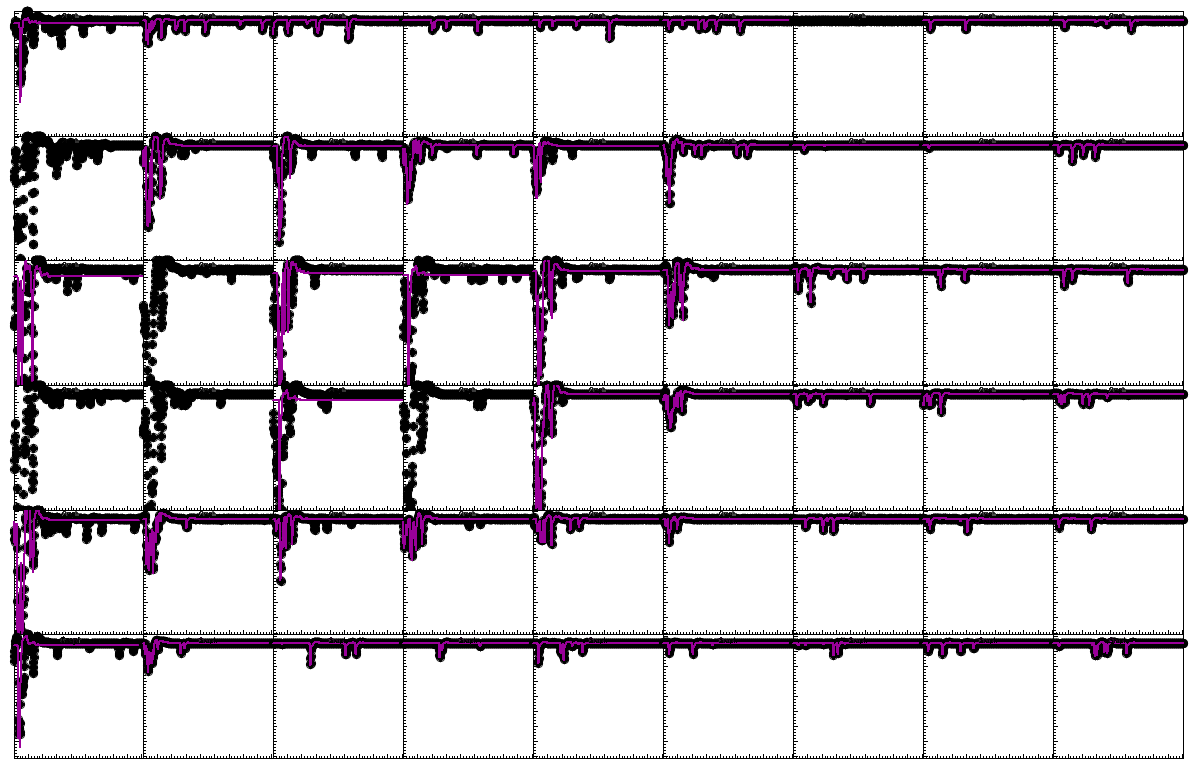

In [3]:
plot_grid_with_index(50000,0)

### Let's look at some of the multifit plots.

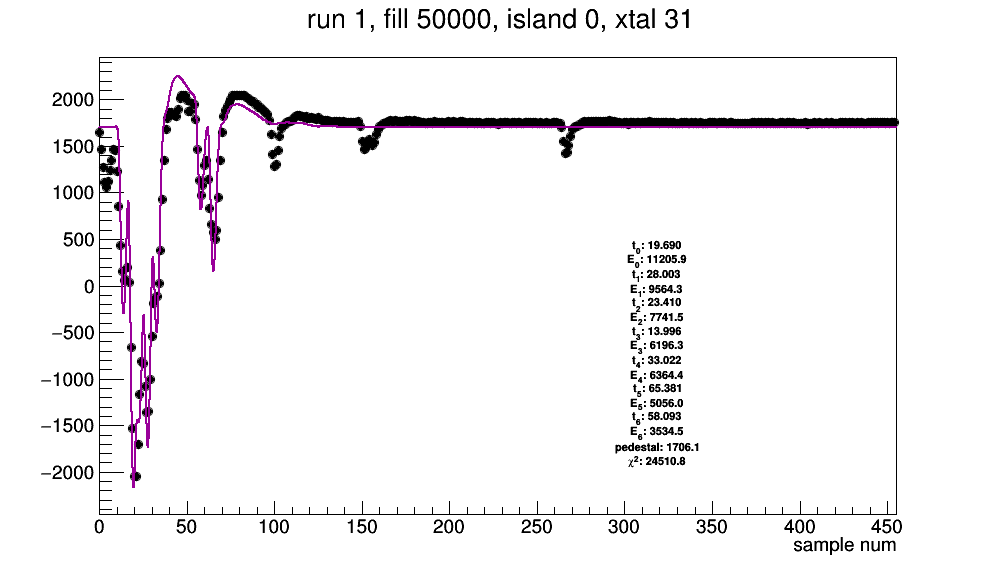

In [4]:
plot_one_with_index(50000,0,31)

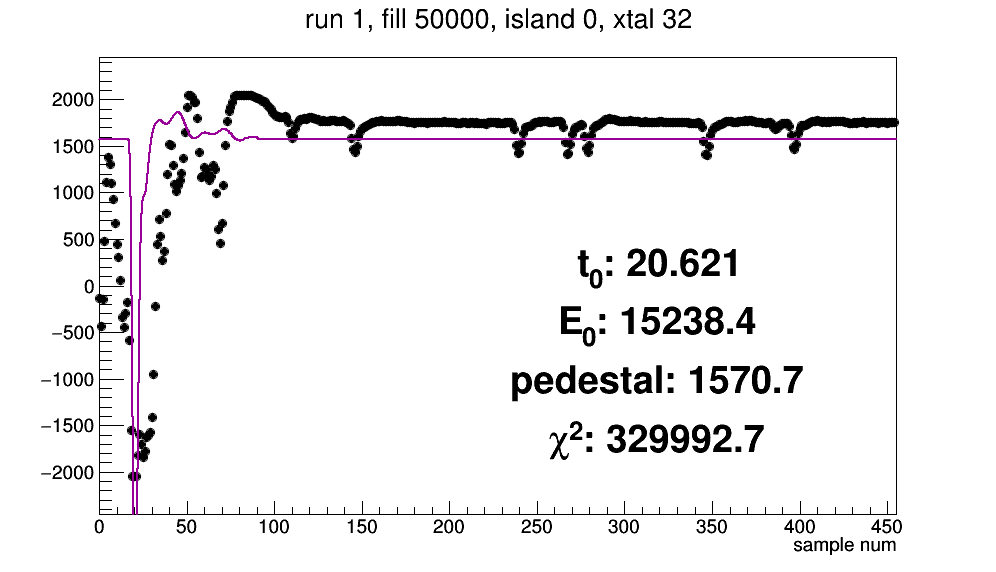

In [5]:
plot_one_with_index(50000,0,32)

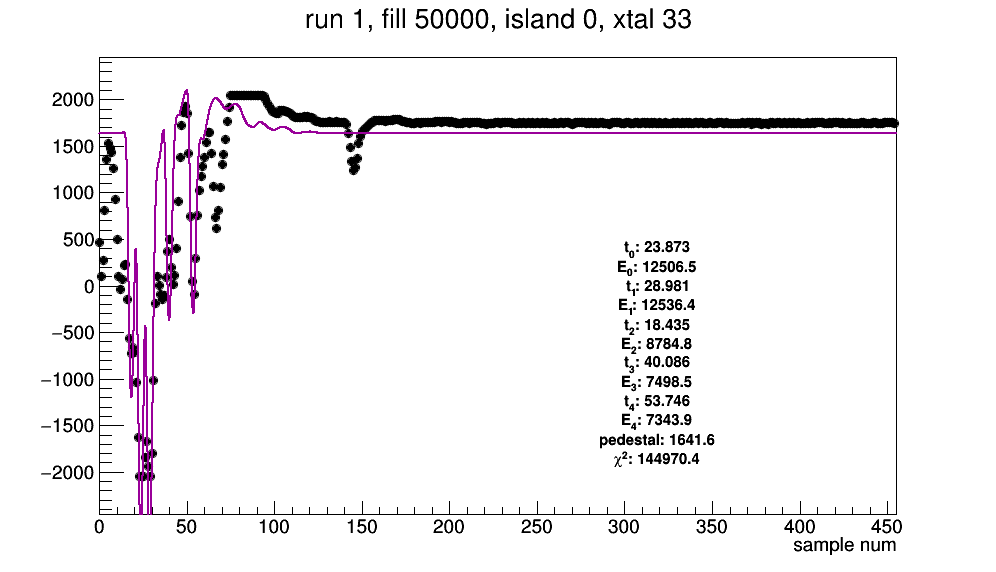

In [6]:
plot_one_with_index(50000,0,33)

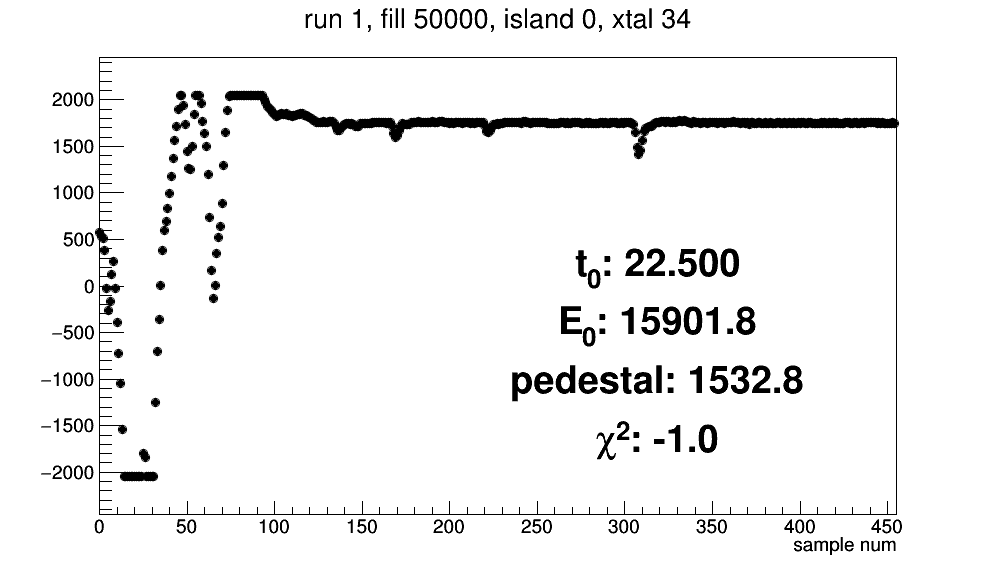

In [7]:
plot_one_with_index(50000,0,34)

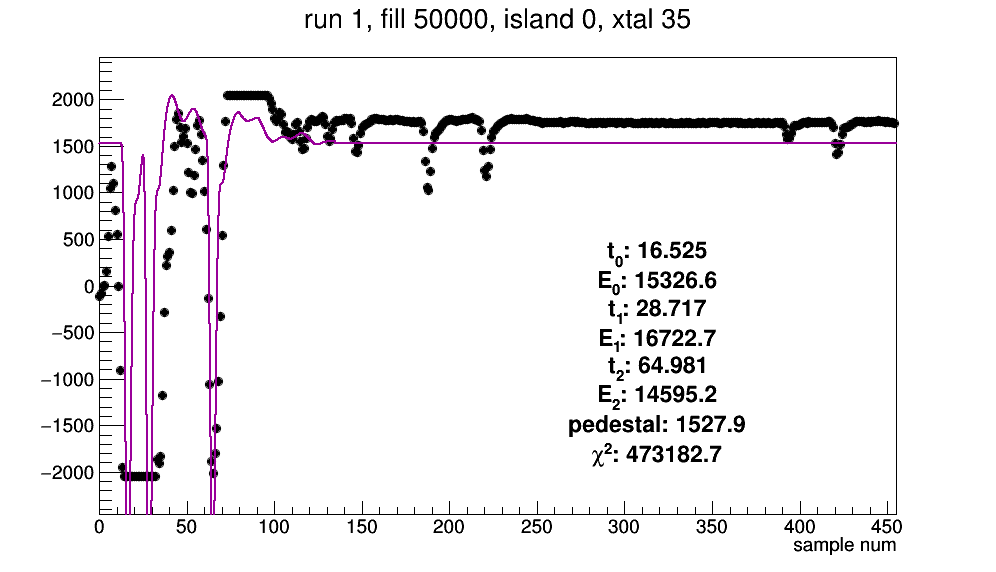

In [8]:
plot_one_with_index(50000,0,35)